In [14]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import scipy 

era5_variables_dict = {
    '10m_u_component_of_wind': {
        'plevel': None,
        'short_name': 'u10'
    }, 
    '10m_v_component_of_wind': {
        'plevel': None,
        'short_name': 'v10'
    }, 
    '2m_temperature': {
        'plevel': None,
        'short_name': 't2m'
    }, 
    'mean_sea_level_pressure': {
        'plevel': None,
        'short_name': 'msl'
    }, 
    'sea_surface_temperature': {
        'plevel': None,
        'short_name': 'sst'
    }, 
    'surface_net_solar_radiation': {
        'plevel': None,
        'short_name': 'ssr'
    }, 
    'surface_net_thermal_radiation': {
        'plevel': None,
        'short_name': 'str'
    }, 
    'sea_ice_cover': {
        'plevel': None
    }, 
    'land_sea_mask': {
        'plevel': None
    }, 
    'geopotential': {
        'plevel': '500',
        'short_name': 'z'
    }
}
DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

### Inputs/outputs

In [8]:
nsidc_sic = xr.open_dataset(f'{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc')

# For some reason, there are two months containing missing data (all the sea ice extent is NaN)
# For now, just remove those times from consideration 
nsidc_sic = nsidc_sic.sel(time=nsidc_sic.time[np.isnan(nsidc_sic.siconc).sum(dim=('x', 'y')) == 0])

land_mask = np.logical_or(nsidc_sic.siconc.isel(time=0) == 2.53, nsidc_sic.siconc.isel(time=0) == 2.54)
all_zeros_mask = np.sum(nsidc_sic.siconc == 0, axis=0) == len(nsidc_sic.time)
land_and_open_ocean_mask = ~np.logical_or(land_mask.values, all_zeros_mask.values)

In [9]:
nsidc_sic

<xarray.Dataset>
Dimensions:                           (time: 546, y: 332, x: 316)
Coordinates:
  * time                              (time) datetime64[ns] 1978-11-01 ... 20...
    xgrid                             (x) float32 ...
    ygrid                             (y) float32 ...
Dimensions without coordinates: y, x
Data variables:
    siconc                            (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    nsidc_bt_seaice_conc_monthly      (time, y, x) float32 ...
    nsidc_nt_seaice_conc_monthly      (time, y, x) float32 ...
    projection                        (time) |S1 ...
    qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 ...
    stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 ...
Attributes: (12/42)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-22T15:54:57Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         1978-11-30T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

Below is an example of this missing data. It occurs for 1987 December and 1988 January

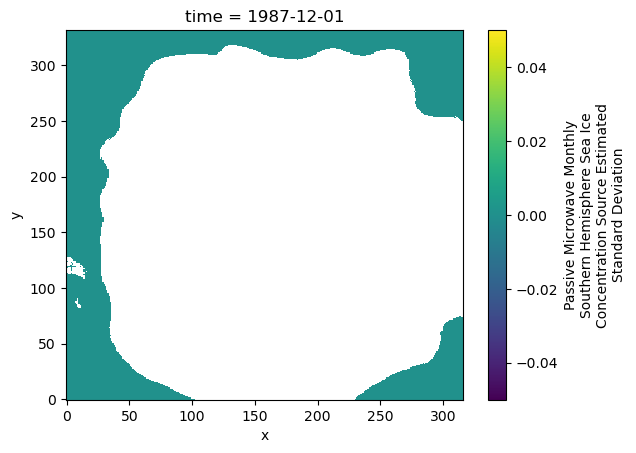

In [100]:
nsidc_sic.stdev_of_cdr_seaice_conc_monthly.sel(time=pd.to_datetime('1987-12')).plot()

In [6]:
target_month = pd.to_datetime('2020-12')
initial_year = pd.to_datetime('1987-11')

# subset 
subset_target_months = nsidc_sic.siconc.sel(time=nsidc_sic.time.dt.month == target_month.month)
subset_target_months = subset_target_months.sel(time=slice(initial_year, target_month - pd.DateOffset(years=1)))

def linear_regress_array(x_arr, y_arr, axis=0, mask=None):
    num_dimensions = y_arr.ndim
    
    if axis >= num_dimensions or axis < 0:
        raise ValueError(f"Axis {axis} is out of bounds for array of dimension {num_dimensions}")
    
    if x_arr.ndim == 1:
        if len(x_arr) != y_arr.shape[axis]:
            raise ValueError(f"Length of x_arr must match the size of y_arr along axis {axis}")

    if mask is None:
        mask = np.ones_like(y_arr, dtype=bool)
        
    # Get the shape of the input array and modify it for the output array
    original_shape = list(y_arr.shape)
    modified_shape = original_shape.copy()
    modified_shape[axis] = 2
    result_array = np.empty(modified_shape)
    
    # Iterate over all slices along the specified axis and perform linear regression
    start_time = time()
    it = np.nditer(np.zeros(original_shape), flags=['multi_index'])
    while not it.finished:
        idx = it.multi_index

        y_slice_index = list(idx)
        y_slice_index[axis] = slice(None)

        mask_index = idx[:axis] + idx[axis+1:]
        mask_slice = mask[mask_index]
        if np.any(mask_slice):
            # Select the current slices of x_arr and y_arr
            if x_arr.ndim == 1:
                x_slice = x_arr
            else:
                x_slice = x_arr[tuple(y_slice_index)]
            
            y_slice = y_arr[tuple(y_slice_index)]
            A = np.vstack([x_slice, np.ones_like(x_slice)]).T
            slope, intercept = np.linalg.lstsq(A, y_slice, rcond=None)[0]
        else:
            slope, intercept = 0.0, 0.0
        
        # Store the results in the result_array
        result_array[tuple(y_slice_index)] = [slope, intercept]
        
        it.iternext()

    end_time = time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.4f} seconds")

    return result_array



test_reg_result = linear_regress_array(subset_target_months.time.dt.year.values, subset_target_months.values, mask=land_and_open_ocean_mask)

Elapsed time: 70.1704 seconds


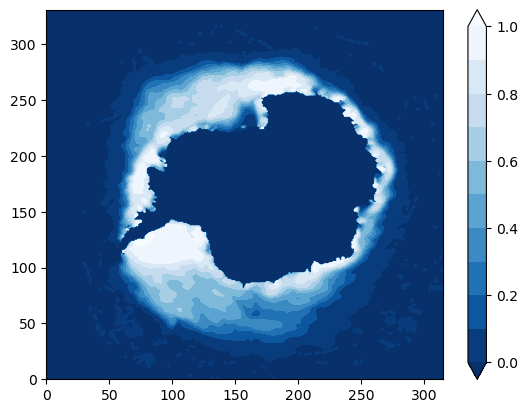

In [18]:
prediction = test_reg_result[0] * target_month.year + test_reg_result[1]
plt.contourf(prediction, levels=np.arange(0, 1.1, 0.1), cmap='Blues_r', extend='both')
plt.colorbar()

In [29]:
os.path.join(DATA_DIRECTORY, "test.nc")

'/scratch/groups/earlew/yuchen/test.nc'

In [50]:
TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')

vars_to_normalize = ["10m_u_component_of_wind"]
save_dir = os.path.join(DATA_DIRECTORY, "sicpred/normalized_inputs")

for var_name in vars_to_normalize:
    if os.path.exists(os.path.join(save_dir, f"{var_name}_norm.nc")):
        print(f"Already found normalized file for {var_name}. Skipping...")
        continue

    print(f"Normalizing {var_name}...")
    if var_name == "siconc":
        ds = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
        da = ds[var_name].sel(time=TRAIN_MONTHS)

    elif var_name == "geopotential":
        ds = xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/{var_name}_500hPa_SPS.nc")
        da = ds[era5_variables_dict[var_name]["short_name"]].sel(time=TRAIN_MONTHS)

    else:
        if not os.path.exists(f"{DATA_DIRECTORY}/ERA5/{var_name}_SPS.nc"):
            raise FileNotFoundError(f"{DATA_DIRECTORY}/ERA5/{var_name}_SPS.nc does not exist!")

        ds = xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/{var_name}_SPS.nc")
        da = ds[era5_variables_dict[var_name]["short_name"]].sel(time=TRAIN_MONTHS)

    print("Calculating means and stdev...", end="")
    monthly_means = da.groupby("time.month").mean("time")
    monthly_stdevs = da.groupby("time.month").std("time")
    print("done!")
    
    months = da['time'].dt.month
    normalized_da = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        da,
        monthly_means.sel(month=months),
        monthly_stdevs.sel(month=months),
        output_dtypes=[da.dtype]
    )

    os.makedirs(save_dir, exist_ok=True)
    print("Saving...", end="")
    normalized_da.to_netcdf(os.path.join(save_dir, f"{var_name}_norm.nc"))
    print("done!")

        

Normalizing 10m_u_component_of_wind...


KeyError: "not all values found in index 'time'"

In [58]:
missing_times = []
for time in TRAIN_MONTHS:
    if time not in ds.time.values:
        missing_times.append(time)
        print(time)

1981-12-01 00:00:00
1982-10-01 00:00:00
1983-09-01 00:00:00
1983-11-01 00:00:00
1985-05-01 00:00:00
1985-11-01 00:00:00
1987-01-01 00:00:00
1987-03-01 00:00:00
1987-04-01 00:00:00
1987-06-01 00:00:00
1988-03-01 00:00:00
1988-06-01 00:00:00
1988-09-01 00:00:00
1988-12-01 00:00:00
1989-02-01 00:00:00
1989-04-01 00:00:00
1989-06-01 00:00:00
1989-10-01 00:00:00
2000-10-01 00:00:00
2001-10-01 00:00:00
2001-11-01 00:00:00
2004-09-01 00:00:00
2005-06-01 00:00:00
2008-08-01 00:00:00
2008-12-01 00:00:00
2010-07-01 00:00:00
2010-10-01 00:00:00
2011-02-01 00:00:00
2012-02-01 00:00:00


In [64]:
ds.isel(time=slice(40,50))

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 10, ygrid: 332, xgrid: 316)
Coordinates:
  * time     (time) datetime64[ns] 80B 1981-05-01 1981-06-01 ... 1982-03-01
  * ygrid    (ygrid) float32 1kB 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid    (xgrid) float32 1kB -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
Data variables:
    u10      (time, ygrid, xgrid) float32 4MB ...
Attributes:
    regrid_method:  bilinear